In [1]:
from manifold_learning import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N_sys = 5

# Generate X axes of Lorenz systems starting from different initial state
X = np.concatenate([get_truncated_lorenz_rand(280,n_steps=30000).T for i in range(N_sys)])

X_emb = [utils.get_td_embedding_np(x[:,None],5,30,return_pred=False)[:,:,0] for x in X]

In [3]:
np.array(X_emb).shape

(15, 29880, 5)

In [5]:
ccm = CCM.FastCCM(device="cpu")

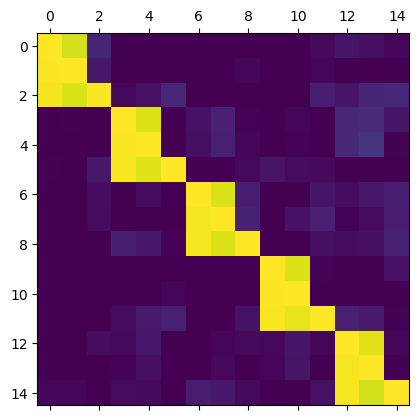

In [33]:
plt.matshow(ccm.compute(X_emb,X_emb,2000,500,30,5,0)[0],vmax=1,vmin=0)